# Naïve Bayes Classifier

### Dataset

UCI SMS Spam Collection Data Set URL: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#

The SMS Spam Collection is a public set of SMS labeled messages that have been collected for mobile phone spam research.

This dataset includes:
- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages.
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: 
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis. 
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages.

In [52]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.datasets import fetch_20newsgroups

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\onsai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part A: Model Code

### Design a Multinomial Naïve Bayes classifier for performing binary classification on the SMS Spam collection dataset.

In [ ]:
class NB_Multinomial(object):
    def __init__(self, alpha=1.0):
        self.alpha = 1.0
        self.params = {} 
    
    def fit(self, X, Y):
        '''
        Arguments:
            X: ndarray A numpy array with rows representing data samples and columns representing numerical features.
            Y: ndarrayA 1D numpy array with labels corresponding to each row of the feature matrix X.
            
        Returns: 
            No return value necessary.
        '''
        
        self.X = X
        self.y = Y
        
        N, D = self.X.shape
        
        class_prior = self.y.sum() / N
        self_param['class_prior'] = class_prior
        feature_likelihood = np.sum(self.X * np.reshape(self.y, (-1,1)), axis=0) / np.sum(self.X * np.reshape(self.y, (-1,1)), axis=0).sum() #total = 1?
        self_param['feature_likelihood'] = feature_likelihood
    
    def predict(self, X):
        '''
        This method performs classification on an array of test vectors X. Use log probabilities to avoid overflow.
        
        Arguments:
            X: ndarray A numpy array containing samples to be used for prediction. 
                Its rows represent data samplesand columns represent numerical features.
                
        Returns:
            1D array of predictions for each row in X.The 1D array should be designed as a column vector.
        '''
        #(N,1) = (N,D) dot (D,1)
        return X.dot(self.params['w']).reshape(-1) #(N,D) dot (D,1) = (N,1)
    
    def predict_proba(self, X):
        '''
        This method returns probability estimates for the test matrix X.
        
        Arguments:
            X: ndarray A numpy array containing samples to be used for prediction. 
            Its rows represent data samples and columns represent numerical features.
            
        Returns: 
            A numpy array that contains probability of the samples (unnormalized posterior) for each class in the model. 
            The number rows is equal to the rows in X and number of columns is equal to the number of classes.
        '''
        
    def predict_log_proba(self, X):
        '''
        This method returns log-probability estimates for the test matrix X.
        
        Arguments:
            X: ndarray A numpy array containing samples to be used for prediction. 
            Its rows represent data samples and columns represent numerical features.
            
        Returns:
            A numpy arraythat contains log-probability of the samples(unnormalized log posteriors)for each class in the model.
            The number rows is equal to the rows in X and number of columns is equal to the number of classes.
        '''
        
    def loss(self, X, y):
        '''
        Inputs:
        - X: np array of shape (N,D)
        - y: np  array of shape (N,1)
        '''
        N, D = self.X.shape
        #forward pass
        #(N,1) = (N,D) dot (D, 1)
        scores = X.dot(self.params['w'])
        
        #backward pass
        loss, dw = 0.0, None
        loss = (0.5/N) * np.sum((y-scores)**2)
        #get mse loss and dout here
        #(N,1) = (N,1) - (N,1)
        dout = (1./N) * (scores - y)
        
        
        #y = wx + b -> dy/db = dout/dy * dy/db = dout * 1.0
        
        #dout/dw = dout/dy dot dy/dw = dout dot x
        #(D,1) = (D,N) dot (N, 1)
        dw = X.T.dot(dout)
        #add regulirizer strength
        if self.regularizer is 'l2':
            loss += (self.lambd/N)*np.sum(self.params['w']**2)
            dw += (self.lambd/N)*self.params['w']
        elif self.regularizer is 'l1':
            loss += (self.lambd/N)*np.sum(self.params['w'])
            dw += (self.lambd/N)*(1/2) * (self.params['w']/np.abs(self.params['w'])) 
            
        #perform clip grad to avoid grad explosion
        dw = np.clip(dw, a_min=-1.0, a_max=1.0)
        return loss, dw
    
    def fit(self, X, Y, learning_rate=1e-1, 
                   epochs=300, tol=None, regularizer=None,
                   lambd=0.0001, verbose=False, lr_decay=0.95,
                   batch_size=None):
        '''
        Inputs:
        - X: numpy array of inputs vector  (N, D)
        - Y: numpy array of target vector (N,1)
        - learning_rate: float provide the step size
        - epochs: int provide number of passes through in dataset
        - tol: float or None provide the stopping criterion.
         iteration will stop when (loss > previous_loss - tol) 
        - batch_size: python integer indicate number of input feature per batch
         None indicate to use all input feature to train in one batch
         default to None
        - regularizer: string of 'l1' or 'l2'
        - lambd: float provide regularize coeff
        '''
        loss_hist = []
        self.X = X
        self.y = Y
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        self.tol = tol
        self.lambd = lambd
        self.lr_decay = lr_decay
        
        self.epochs = epochs
        
        N, D = self.X.shape
        
        self.params['w'] = np.random.randn(D,1)
        prev_loss = 0.0
        for e in range(self.epochs):
            
            #if no batch gradient descent
            X_batch = self.X
            y_batch = self.y
            
            #if batch gradient descent
            if batch_size: 
                sampling_idxs = np.random.choice(np.arange(N), batch_size, replace=False)#False: mean no repeated
                X_batch = self.X[sampling_idxs] 
                y_batch = self.y[sampling_idxs]
            
            loss, dw = self.loss(X_batch, y_batch)
            
            #SGD
            self.params['w'] -= self.learning_rate * dw
            
            if e % 20 == 0 : 
                self.learning_rate *= self.lr_decay
                if verbose: print('epoch', e, 'loss', loss)
            loss_hist.append(loss)#track the loss
            
            #early stopping
#             if self.tol: 
#                 if loss > (prev_loss - self.tol):
#                     break
            prev_loss = loss
        return loss_hist

## Part B: Exploratory Data Analysis

2. Read in the “SMSSpamCollection.csv” as a pandas data frame.

In [53]:
#crane_path = r'/work/cseos2g/datduyn/Documents/datasets/wine-quality/SMSSpamCollection.csv'
# window_path = r'C:\Users\datng\Documents\datasets\wine-quality\SMSSpamCollection.csv'
#crane_path = r'/home/cse496dl/otiong/machineLearning/assignment_1/SMSSpamCollection.csv'
window_path = r'C:\Users\onsai\CSCE478\datasets\DataScienceRepository\SMSSpamCollection.csv'

df = pd.read_csv(window_path ,delimiter=',', header=None)
df.columns = ["spam", "text"]
df['spam'].replace(['spam', 'ham'], [1,0], inplace=True)
print('Note: Spam will have the value of 1 and ham will have the value of 0')
df.head()

Note: Spam will have the value of 1 and ham will have the value of 0


,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
spam    5574 non-null int64
text    5574 non-null object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [56]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("No. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (5574, 2)
No. of Rows: 5574
No. of Columns: 2


3. Use the techniques from the first recitation to summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles

In [57]:
# Create a new column "length" the stores the length of the text on each row
df['length'] = df['text'].map(lambda text: len(text))
print(df)
df.groupby('spam').length.describe()

      spam                                               text  length
0        0  Go until jurong point, crazy.. Available only ...     111
1        0                      Ok lar... Joking wif u oni...      29
2        1  Free entry in 2 a wkly comp to win FA Cup fina...     155
3        0  U dun say so early hor... U c already then say...      49
4        0  Nah I don't think he goes to usf, he lives aro...      61
5        1  FreeMsg Hey there darling it's been 3 week's n...     148
6        0  Even my brother is not like to speak with me. ...      77
7        0  As per your request 'Melle Melle (Oru Minnamin...     160
8        1  WINNER!! As a valued network customer you have...     158
9        1  Had your mobile 11 months or more? U R entitle...     154
10       0  I'm gonna be home soon and i don't want to tal...     109
11       1  SIX chances to win CASH! From 100 to 20,000 po...     136
12       1  URGENT! You have won a 1 week FREE membership ...     156
13       0  I've bee

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
0,4827.0,71.527035,58.330761,2.0,33.0,52.0,93.0,910.0
1,747.0,139.119143,28.998900,13.0,133.0,149.0,158.0,224.0


### Class Distribution

In [35]:
label_counts = df.iloc[:,0].value_counts()
print(label_counts)

0    4827
1     747
Name: class, dtype: int64


### Visualization of the Class Distribution

4. Generate a bar plot to display the class distribution.You may use “seaborn”s barplot function.

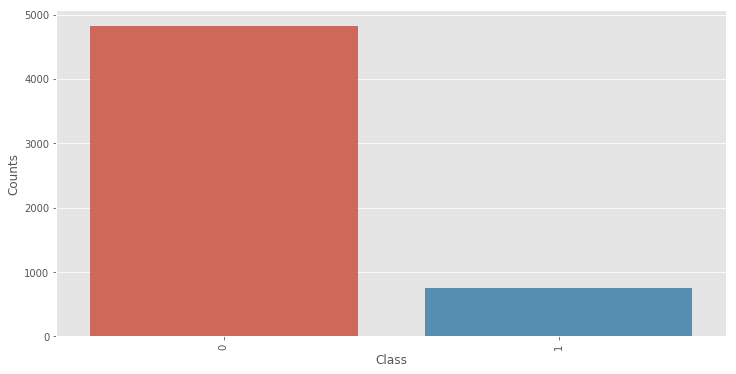

In [36]:
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Part C: Feature Extraction 

Normalize the “text” by performing stemming and lemmatization

In [59]:
lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

'''
def lemmatize_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in [word for word in tokens if word.isalpha()]])
'''

df['text_lemmatized'] = df.text.apply(lemmatize_text)

print(df.shape)

(5574, 4)


### Observe a Random Document Before and After Lemmatization

In [60]:
print(df['text'][4])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][4])

Nah I don't think he goes to usf, he lives around here though

Lemmatized Email:

Nah I don't think he go to usf, he life around here though


6. Generate word clouds for both the spam and ham messages.You may use the NLTK library.

### Generate Wordcloud of Spam Messages

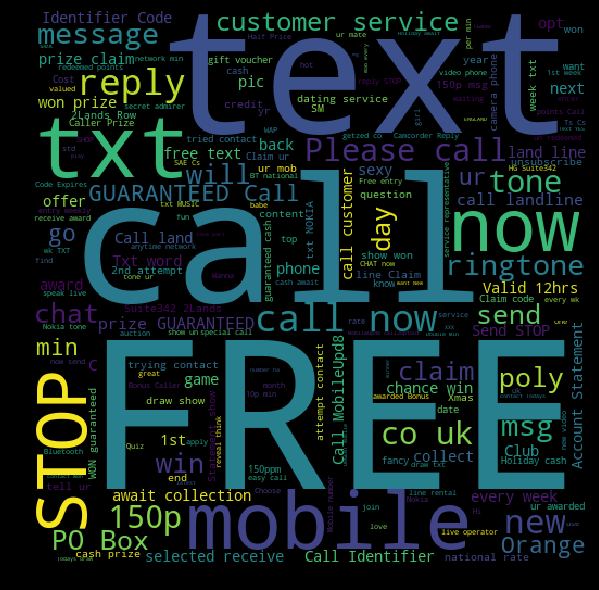

In [62]:
spam_words = ''.join(list(df[df['spam']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Generate Wordcloud of Ham Messages

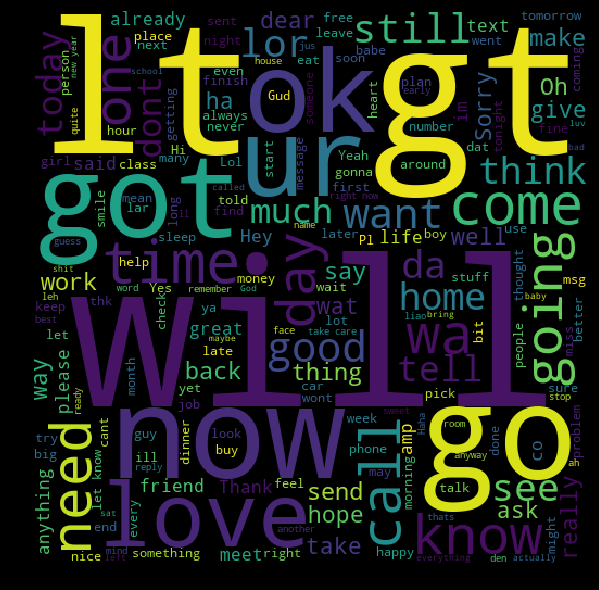

In [63]:
spam_words = ''.join(list(df[df['spam']==0]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Shuffle the data
- Use `def = df.sample(frac=1) ` 

9. Shuffle the rows of your data. You can use def = df.sample(frac=1) as an idiomatic way to shuffle the data in Pandas without losing column name

In [103]:
df = df.sample(frac=1)
df.head()

,spam,text,length,text_lemmatized
2515,0,Ok ill send you with in &lt;DECIMAL&gt; ok.,45,Ok ill send you with in &lt;DECIMAL&gt; ok.
10,0,I'm gonna be home soon and i don't want to tal...,109,I'm gonna be home soon and i don't want to tal...
458,0,I hope you that's the result of being consiste...,158,I hope you that's the result of being consiste...
2613,0,Yes. It's all innocent fun. O:-),32,Yes. It's all innocent fun. O:-)
5105,0,In other news after hassling me to get him wee...,98,In other news after hassling me to get him wee...


7. Remove the stop words from the text and convert the text content into numerical feature vectors. Note that for the multinomial Naïve Bayes classifier you need to count word occurrences as feature values.

In [104]:
count_vect = CountVectorizer(lowercase=True, stop_words='english')
X_lemmatized = df['text_lemmatized']

# Learn the vocabulary dictionary and return term-document matrix.
# This is equivalent to fit followed by transform, but more efficiently implemented.
X_lemmatized_counts = count_vect.fit_transform(X_lemmatized)
print(X_lemmatized_counts.shape)

#print("Type of the occurance count matrix (should be sparse): ")
#print(type(X_lemmatized_counts))

#print("Feature Names:")
#print(count_vect.get_feature_names())

#print("\nVocabulary: ", count_vect.vocabulary_)
#print("Note: After each word the index of that word is given. It's not word count.")

print("\nCount Vector Matrix")
print(X_lemmatized_counts.toarray())


# Read the a "message" from X
print("\nA message:\n")
print("Nah I don't think he go to usf, he life around here though\n")
print("(, index) word count occurences\n")
print(X_lemmatized_counts[4])

print("\nGet the index of the words from the vocabulary:")
print("Vocabulary - Index of think: ", count_vect.vocabulary_.get("think"))
print("Vocabulary - Index of go: ", count_vect.vocabulary_.get("go"))

print("Note: Some of the words are erased because it belongs to stop word")

(5574, 8265)

Count Vector Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

A message:

Nah I don't think he go to usf, he life around here though

(, index) word count occurences

  (0, 3610)	1
  (0, 4892)	1
  (0, 3543)	1
  (0, 1069)	1
  (0, 7925)	1
  (0, 7924)	1
  (0, 3606)	1
  (0, 5089)	1

Get the index of the words from the vocabulary:
Vocabulary - Index of think:  7301
Vocabulary - Index of go:  None
Note: Some of the words are erased because it belongs to stop word


### Create a Separate Feature Set (Data Matrix X) and Target (1D Vector y)

8. Create data or feature matrix X and the target vector Y. The number of columns in X is equal to the number of features.

In [199]:
X = X_lemmatized_counts.toarray()

y = np.array(df['spam']) # 1D targer vector

print(X.shape)
print(y.shape)

(5574, 8265)
(5574,)


### Function to partition data

In [106]:
def split_train_test(X, y, 
                     partition_percent=[.8,.2], shuffle=False):
    '''
    Partioning the data:
    args:
        - X: train set numpy or dataframe with shape(N,D)
        - y: labels numpy or dataframe with shape(N,)
        - partition_percent: python list of data percentage
         to partition. ex: [.8, .2] -> part of data
         will be split to .8 and part will be .2.
         NOTE: have to sum up to 1.0
        - shuffle: shuffle before partitioning or not?
    '''
    
    #convert from panda series to numpy
    try:
        X = X.as_matrix()
        y = y.as_matrix()
    except: #incase given X, y is already a numpy arra
        pass
    
    N = X.shape[0]
    if(sum(partition_percent) != 1.0):
        raise ValueError("Partition_percent should add up to 1.0")
    if shuffle:
        X = np.random.shuffle(X)
    
    split_sets = []
    s = [] #[X1,y1, X2, y2, X3, y3...]
    prev_idx = 0
    for idx,part in enumerate(partition_percent):
        range_idx = int(N * part)
        if(idx == len(partition_percent)-1):
            split_sets.append(X[prev_idx:])
            split_sets.append(y[prev_idx:])
        else:
            split_sets.append(X[prev_idx:prev_idx+range_idx])
            split_sets.append(y[prev_idx:prev_idx+range_idx])
        prev_idx = prev_idx+range_idx
        
    return split_sets

10. Partition the data into train and test set (80%-20%)

In [224]:
X_train, y_train, X_test, y_test= split_train_test(X, y, 
                partition_percent=[.8,.2], 
                shuffle=False)

# Check shape
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (4459, 8265)
y_train (4459,)
X_test (1115, 8265)
y_test (1115,)


## Part D: Model Evaluation

In [255]:
feature_likelihood = np.zeros((5,), dtype=int)
#print(feature_likelihood)
test = np.sum(X, axis=0)
test.shape
#print(y_train)
#print(y_train.sum())
print(X_train)
print(y_train)

print(np.sum(X_train, axis=0))
data_matrix = np.column_stack( (X_train,y_train) )
np.sum(np.sum(X_train * np.reshape(y_train, (-1,1)), axis=0)/np.sum(X_train * np.reshape(y_train, (-1,1)), axis=0).sum(), axis=0)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
[0 0 0 ... 1 0 1]
[ 7 25  0 ...  1  1  1]


1.0

# 5. Dimension the Data